In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
config = f"""
execution:
    debug: False
    submit: False
    multiprocessing: True
    exp_id: exp_015

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs

feature:
    agg_freq: 24 # [step]

seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

In [7]:
train = pd.read_csv(os.path.join("/kaggle/output", os.path.join(CFG["execution"]["exp_id"], "oof.csv")))
train.head()

,target,step,series_id,fold,oof_stage1,STAGE_stage1,raw_oof,oof_stage2,STAGE_stage2,oof
0,1,11.5,038441c925bb,2,NaN,2,0.999819,NaN,NaN,NaN
1,1,35.5,038441c925bb,2,NaN,2,0.999644,NaN,NaN,NaN
2,1,59.5,038441c925bb,2,NaN,2,0.993865,NaN,NaN,NaN
3,1,83.5,038441c925bb,2,NaN,2,0.995005,NaN,NaN,NaN
4,1,107.5,038441c925bb,2,NaN,2,0.994551,NaN,NaN,NaN


In [5]:
labels = pd.read_csv(f'{CFG["dataset"]["competition_dir"]}/train_events.csv')
labels.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [9]:
series_id = train["series_id"].unique()[0]


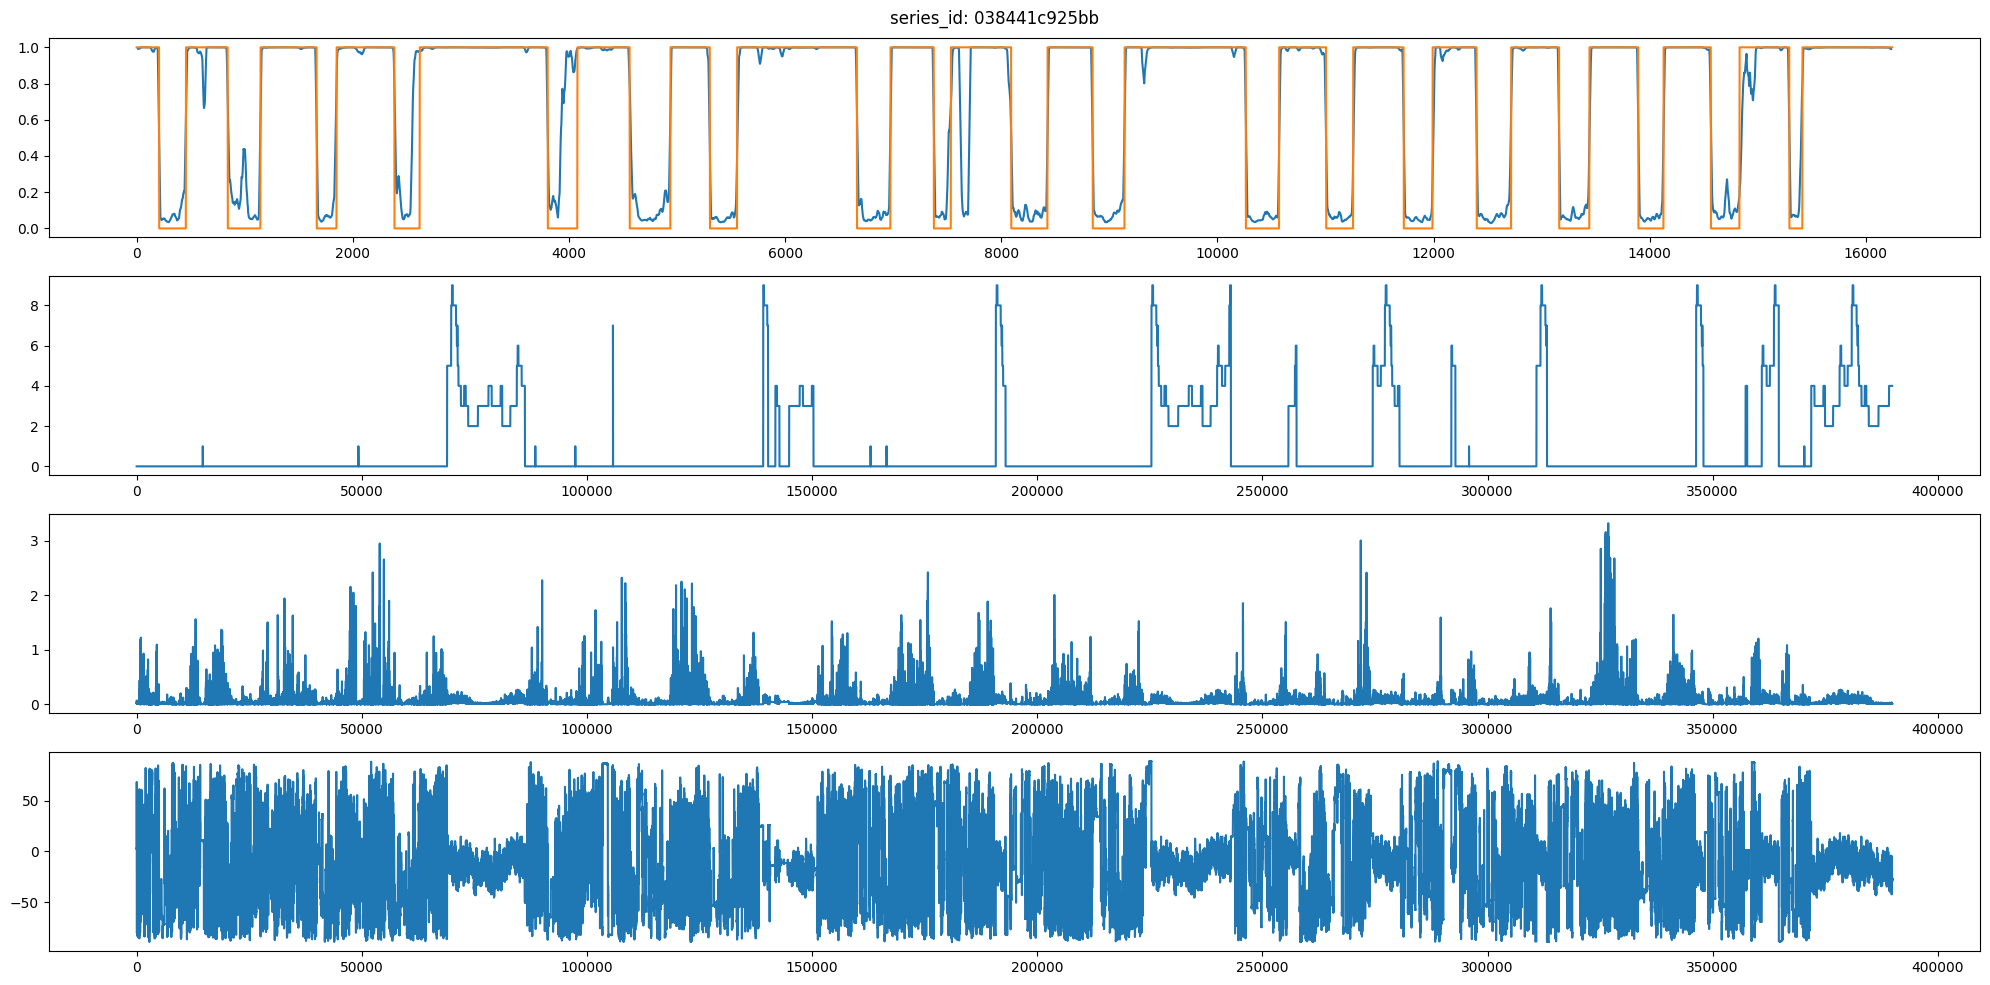

In [53]:
pred_df = train[train["series_id"] == series_id]
df = pd.read_csv(f'{CFG["dataset"]["step_csv_dir"]}/{series_id}.csv')
DAY_STEPS = 60 * 60 * 24 // 5

n_days = int(len(df) // DAY_STEPS) + 1
df["same_count"] = 0
for day in range(-n_days, n_days + 1):
    if day == 0:
        continue
    df["anglez_diff"] = df["anglez"].diff(DAY_STEPS * day)
    df["anglez_diff"] = df["anglez_diff"].fillna(1)
    df["same_count"] += (df["anglez_diff"] == 0).astype(int)

fig, axs = plt.subplots(4, 1, figsize=(20, 10))
axs[0].plot(pred_df["oof"])
axs[0].plot(pred_df["target"])
axs[1].plot(df["same_count"])
axs[2].plot(df["enmo"])
axs[3].plot(df["anglez"])
plt.suptitle(f"series_id: {series_id}")
plt.tight_layout()
plt.show()